In [21]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
from scipy import io as sio

from utils import GenerateHaarFeatureMasks, ExtractHaarFeatures
from classifier import WeakClassifier, WeakClassifierError

plt.rcParams['figure.facecolor']='white'

In [22]:
# Hyper-parameters

# Number of randomized Haar-features
nbrHaarFeatures = 150

# Number of training images, will be evenly split between faces and
# non-faces. (Should be even.)
nbrTrainImages = 1000

# Number of weak classifiers
nbrWeakClassifiers = 60

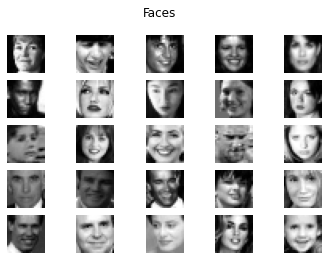

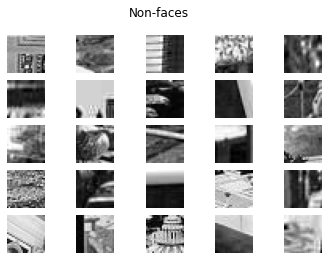

In [23]:
# Load face and non-face data and plot a few examples
faces = sio.loadmat('faces.mat')['faces']
nonfaces = sio.loadmat('nonfaces.mat')['nonfaces']

faces = faces.astype('double')[:,:,np.random.permutation(faces.shape[-1])]
nonfaces = nonfaces.astype('double')[:,:,np.random.permutation(nonfaces.shape[-1])]

plt.figure()
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(faces[:,:,10*i], cmap='gray')
    plt.axis('off')
plt.suptitle('Faces')

plt.figure()
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(nonfaces[:,:,10*i], cmap='gray')
    plt.axis('off')
plt.suptitle('Non-faces')
plt.show()

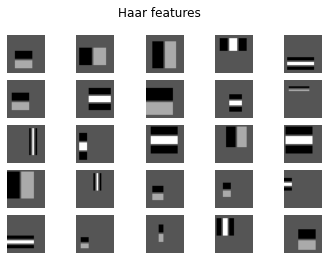

In [24]:
# Generate Haar feature masks
haarFeatureMasks = GenerateHaarFeatureMasks(nbrHaarFeatures)

plt.figure()
for k in range(25):
    plt.subplot(5,5,k+1)
    plt.imshow(haarFeatureMasks[:,:,k], cmap='gray', vmin=-1, vmax=2)
    plt.axis('off')
plt.suptitle('Haar features')
plt.show()

In [25]:
# Create image sets (do not modify!)

# Create a training data set with examples from both classes.
# Non-faces = class label y=-1, faces = class label y=1
trainImages = np.concatenate((faces[:,:,:nbrTrainImages//2], nonfaces[:,:,:nbrTrainImages//2]), axis=2)
xTrain = ExtractHaarFeatures(trainImages,haarFeatureMasks)
yTrain = np.concatenate((np.ones(nbrTrainImages//2), -np.ones(nbrTrainImages//2)))

# Create a test data set, using the rest of the faces and non-faces.
testImages  = np.concatenate((faces[:,:,nbrTrainImages//2:], nonfaces[:,:,nbrTrainImages//2:]), axis=2)
xTest = ExtractHaarFeatures(testImages,haarFeatureMasks)
yTest = np.concatenate((np.ones(faces.shape[2]-nbrTrainImages//2), -np.ones(nonfaces.shape[2]-nbrTrainImages//2)))

# Variable for the number of test-data.
nbrTestImages = yTest.shape

In [26]:
# Implement the AdaBoost training here
# Use your implementation of WeakClassifier and WeakClassifierError in classifier.py
D = np.full(nbrTrainImages, (1/nbrTrainImages))
classifiers = np.zeros((nbrWeakClassifiers, 4)) #(haarfeature, threshold, p, aplhas)
for classifier in range(0, nbrWeakClassifiers):
    print("Looking for classifier :", classifier)
    minError = 0.5
    for feature in range(0, nbrHaarFeatures):
        thresholds = np.unique(xTrain[feature])
        
        for threshold in thresholds:
            p = 1
            C = WeakClassifier(threshold, p, xTrain[feature])
            err = WeakClassifierError(C, D, yTrain)
            
            if err > 0.5:
                err = 1 - err
                p = -1
            
            if (err < minError):
                minError = err
                classifiers[classifier, 0] = feature
                classifiers[classifier, 1] = threshold
                classifiers[classifier, 2] = p
    
    f = classifiers[classifier, 0]
    t = classifiers[classifier, 1]
    p = classifiers[classifier, 2]
    a = 0.5 * np.log((1.0 - minError + 0.001) / (minError + 0.001))
    
    classifiers[classifier, 3] = a
    
    
    D = D * np.exp(-a * yTrain * WeakClassifier(t, p, xTrain[int(f)]))
    D /= np.sum(D)
    

Looking for classifier : 0
Looking for classifier : 1
Looking for classifier : 2
Looking for classifier : 3
Looking for classifier : 4
Looking for classifier : 5
Looking for classifier : 6
Looking for classifier : 7
Looking for classifier : 8
Looking for classifier : 9
Looking for classifier : 10
Looking for classifier : 11
Looking for classifier : 12
Looking for classifier : 13
Looking for classifier : 14
Looking for classifier : 15
Looking for classifier : 16
Looking for classifier : 17
Looking for classifier : 18
Looking for classifier : 19
Looking for classifier : 20
Looking for classifier : 21
Looking for classifier : 22
Looking for classifier : 23
Looking for classifier : 24
Looking for classifier : 25
Looking for classifier : 26
Looking for classifier : 27
Looking for classifier : 28
Looking for classifier : 29
Looking for classifier : 30
Looking for classifier : 31
Looking for classifier : 32
Looking for classifier : 33
Looking for classifier : 34
Looking for classifier : 35
Lo

In [27]:
# Evaluate your strong classifier here
# Evaluate on both the training data and test data, but only the test accuracy
# can be used as a performance metric since the training accuracy is biased.

trainAcc = np.zeros(nbrWeakClassifiers)
testAcc = np.zeros(nbrWeakClassifiers)

Htrain = np.zeros(nbrTrainImages)
Htest = np.zeros(nbrTestImages)
for classifier in range(0, nbrWeakClassifiers):
    f = classifiers[classifier, 0]
    t = classifiers[classifier, 1]
    p = classifiers[classifier, 2]
    a = classifiers[classifier, 3]
    
    Htrain = Htrain + a * WeakClassifier(t, p, xTrain[int(f)])
    Htest = Htest + a * WeakClassifier(t, p, xTest[int(f)])

    trainAcc[classifier] = np.sum((np.abs(np.sign(Htrain)+yTrain)/2))/nbrTrainImages
    testAcc[classifier] = np.sum((np.abs(np.sign(Htest)+yTest)/2))/nbrTestImages[0]

finalTrainAcc = trainAcc[classifier]
print("Final Train acc:", finalTrainAcc)
finalTestAcc = testAcc[classifier]
print("Final Test acc:", finalTestAcc)


Final Train acc: 1.0
Final Test acc: 0.9419748897183576


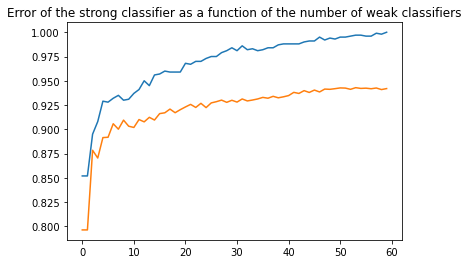

In [28]:
# Plot the error of the strong classifier as a function of the number of weak classifiers.
# Note: you can find this error without re-training with a different number of weak classifiers.
plt.title("Error of the strong classifier as a function of the number of weak classifiers")
plt.plot(trainAcc)
plt.plot(testAcc)


Text(0.5, 0.98, 'These non-faces got classefied as faces')

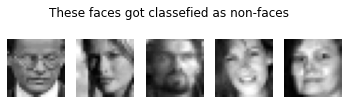

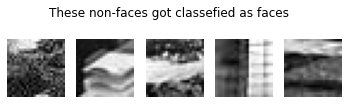

In [29]:
# Plot some of the misclassified faces and non-faces
# Use the subplot command to make nice figures with multiple images.

plt.figure()
x = np.sign(Htest) + yTest
i=0
j=0
while i < 5:
    if x[j] == 0 and yTest[j] == 1:
        plt.subplot(3,5,i+1)
        plt.imshow(faces[:,:,j], cmap='gray')
        plt.axis('off')
        i+=1
    j+=1
plt.suptitle('These faces got classefied as non-faces')

plt.figure()
x = np.sign(Htest) + yTest
i=0
j=0
while i < 5:
    if x[j] == 0 and yTest[j] == -1:
        plt.subplot(3,5,i+1)
        plt.imshow(nonfaces[:,:,j], cmap='gray')
        plt.axis('off')
        i+=1
    j+=1
plt.suptitle('These non-faces got classefied as faces')



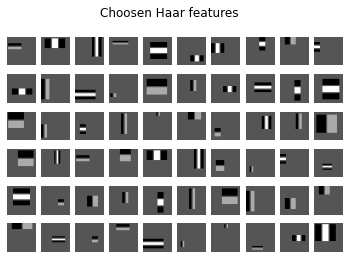

In [30]:
# Plot your choosen Haar-features
# Use the subplot command to make nice figures with multiple images.
plt.figure()
for classifier in range(0, nbrWeakClassifiers):
    plt.subplot(6,10,classifier+1)
    plt.imshow(haarFeatureMasks[:,:,int(classifiers[classifier, 0])], cmap='gray', vmin=-1, vmax=2)
    plt.axis('off')
plt.suptitle('Choosen Haar features')
plt.show()    
